In [1]:
#Importo las librerías necesarias
from sklearn.preprocessing import MinMaxScaler

import numpy as np
#Semilla para asegurar valores aleatorios
np.random.seed(10)

import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers

Cargo los datos, luego los separo por entradas y los normalizo

In [2]:
data = pd.read_csv("D:\\Programas\\OneDrive - Estudiantes ITCR\\TEC\\Semestre 9\\IA\\Tareas\\Tarea1_IA\\ParteA\\synchronous machine.csv", sep=';')

X=data[["Iy", "PF", "e", "dIf"]]
y=data[["If"]]
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler1.fit(X)
X_data = scaler1.transform(X)

scaler2 = MinMaxScaler(feature_range=(0, 1))
scaler2.fit(y)
y_data = scaler2.transform(y)

Divido los datos en datos de entrenamiento y datos de testeo
60% entrenamiento, 40% para test

In [3]:
X_train,X_test,y_train,y_test = train_test_split(X_data, y_data, test_size=0.4, random_state=42)

Las siguientes funciones sirven para imprimir la curva de aprendizaje de la red

In [4]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,0.7])
  plt.legend()
  plt.show()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Squared Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,0.7])
  plt.legend()
  plt.show()

Se definen los parámetros de la red neuronal

In [57]:
model = keras.Sequential([
  layers.Dense(6, activation='sigmoid', input_shape=[4]), #Número de entradas
  layers.Dense(6, activation='sigmoid'),

  layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001) #Define el optimizador

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
               metrics=['accuracy', "mae", "mse"])


Entreno el modelo e imprimo la curva de aprendizaje

Epoch 1/1000
1/1 [==============================] - 1s 648ms/step - loss: 0.0942 - accuracy: 0.0030 - mae: 0.3562 - mse: 0.1884 - val_loss: 0.0768 - val_accuracy: 0.0090 - val_mae: 0.3149 - val_mse: 0.1535
Epoch 2/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.0934 - accuracy: 0.0030 - mae: 0.3543 - mse: 0.1868 - val_loss: 0.0762 - val_accuracy: 0.0090 - val_mae: 0.3133 - val_mse: 0.1523
Epoch 3/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.0927 - accuracy: 0.0030 - mae: 0.3526 - mse: 0.1855 - val_loss: 0.0756 - val_accuracy: 0.0090 - val_mae: 0.3118 - val_mse: 0.1513
Epoch 4/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.0921 - accuracy: 0.0030 - mae: 0.3511 - mse: 0.1843 - val_loss: 0.0751 - val_accuracy: 0.0090 - val_mae: 0.3105 - val_mse: 0.1503
Epoch 5/1000
1/1 [==============================] - 0s 43ms/step - loss: 0.0916 - accuracy: 0.0030 - mae: 0.3497 - mse: 0.1832 - val_loss: 0.0747 - val_accuracy: 0.0090 - val_mae:

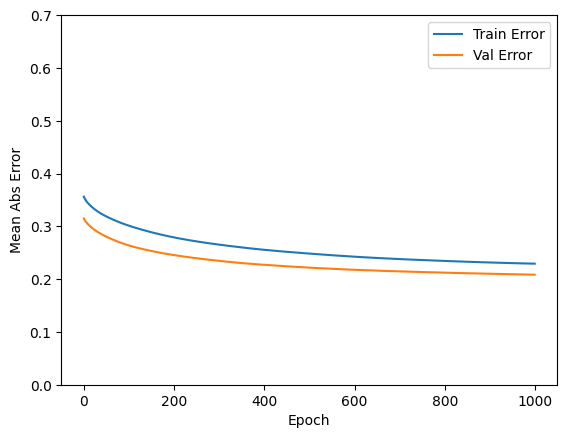

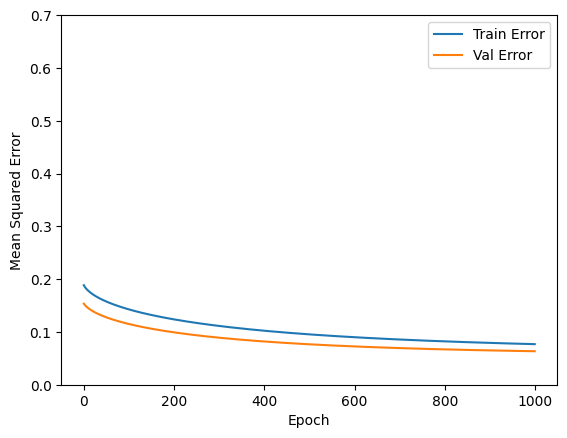

In [58]:
history = model.fit(X_train,y_train,
                    validation_data=(X_test, y_test),
                    epochs = 1000,
                    batch_size=512, 
                    verbose = 1, 
                    callbacks = [PrintDot()])

plot_history(history)

In [59]:
'''
# Se serializa el modelo en formato JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)

# Se serializan los pesos a formato HDF5
model.save_weights("model.h5")
print("Modelo Guardado!")
'''

'\n# Se serializa el modelo en formato JSON\nmodel_json = model.to_json()\nwith open("model.json", "w") as json_file:\n  json_file.write(model_json)\n\n# Se serializan los pesos a formato HDF5\nmodel.save_weights("model.h5")\nprint("Modelo Guardado!")\n'

A partir de este punto está el código de implementación de la red

Alimento el modelo ya entrenado con las 80 combinaciones de entradas para el punto 3 A

In [60]:
'''
prueba = pd.read_csv("datos_combinaciones.csv")

model.predict(prueba)
'''

'\nprueba = pd.read_csv("datos_combinaciones.csv")\n\nmodel.predict(prueba)\n'

Punto 3 B: utilización del modelo para realizar una clasificación tipo Ceteris Paribus en un conjunto de datos generados manualmente al variar en 5%, 10%, 20%, 40% y 60% cada uno de los datos de las columnas individualmente.

In [61]:
'''
prueba = pd.read_csv("DatosParaCeterisParibus.csv")
#prueba = mean_norm(prueba)
model.predict(prueba)
'''

'\nprueba = pd.read_csv("DatosParaCeterisParibus.csv")\n#prueba = mean_norm(prueba)\nmodel.predict(prueba)\n'